# Melhores métodos de clusterização

## Comparar os três cenários entre embeddings completos, PCA (n_componentes = x) ou UMAP (n_componentes=y)

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

base_clusters_path = 'clusters/'


In [2]:
def collect_files_from_path(path_to_search, dataset, reduction_method, n_components, all_results_dfs):
    """
    Função auxiliar para coletar arquivos CSV de resultados de clusterização de um dado caminho.
    Coleta diretamente do path_to_search, assumindo que os CSVs estão lá.
    """
    found_result_files = []

    # Procura os arquivos CSV diretamente no path_to_search
    # Não vamos mais inspecionar subpastas 'run_*' para os CSVs aqui,
    # pois a estrutura do usuário indica que os CSVs estão no mesmo nível que essas pastas.
    if not os.path.exists(path_to_search):
        # print(f"Aviso: Caminho não encontrado {path_to_search}. Pulando.") # Opcional: descomentar para debug
        return

    files_in_current_path = [f for f in os.listdir(path_to_search) if f.endswith('_results.csv')]
    for f in files_in_current_path:
        found_result_files.append(os.path.join(path_to_search, f))

    if not found_result_files:
        # print(f"Aviso: Nenhum arquivo '_results.csv' encontrado em {path_to_search}.") # Opcional: descomentar para debug
        return # Não há arquivos para processar nesta pasta

    for file_path in found_result_files:
        try:
            df = pd.read_csv(file_path)
            if df.empty: # Checagem adicional se o CSV estiver vazio
                print(f"Aviso: Arquivo CSV vazio encontrado e pulado: {file_path}")
                continue

            df['Dataset'] = dataset
            df['Reduction_Method'] = reduction_method
            df['N_Components'] = n_components

            if 'Metric_Distance' in df.columns:
                df = df.drop(columns=['Metric_Distance'])

            df['Actual_Clusters'] = np.nan
            df['Input_K_Param'] = np.nan

            if 'N_Clusters_Actual' in df.columns:
                df['Actual_Clusters'] = df['N_Clusters_Actual']
                if 'k' in df.columns:
                    df['Input_K_Param'] = df['k']
                elif 'min_cluster_size' in df.columns:
                    df['Input_K_Param'] = df['min_cluster_size']
            elif 'k' in df.columns:
                df['Actual_Clusters'] = df['k']
                df['Input_K_Param'] = df['k']
            elif 'min_cluster_size' in df.columns:
                df['Input_K_Param'] = df['min_cluster_size']

            if 'Method' not in df.columns:
                # Tenta inferir o nome do método a partir do nome do arquivo
                # Ex: ML-1M_run_kmeans_results.csv -> kmeans
                # Ou: PetSupplies_run_kmeans_results.csv -> kmeans
                base_name = os.path.basename(file_path)
                # Remove o sufixo '_results.csv'
                name_without_suffix = base_name.replace('_results.csv', '')
                # Pega a última parte após o último '_' que deve ser o nome do método,
                # lidando com prefixos como 'run_'
                parts = name_without_suffix.split('_')
                method_name_from_file = parts[-1] if not parts[-1].isdigit() else parts[-2] # Pega o último ou penúltimo se o último for dígito (raro)
                if parts[-2] == 'run': # Se o padrão for Dataset_run_method
                     method_name_from_file = parts[-1]

                df['Method'] = method_name_from_file.capitalize()
            else:
                df['Method'] = df['Method'].str.replace('run_', '').str.capitalize()

            all_results_dfs.append(df)
        except pd.errors.EmptyDataError:
            print(f"Erro ao ler arquivo {file_path}: Sem colunas para analisar. (Arquivo pode estar vazio ou mal formatado)")
        except Exception as e:
            print(f"Erro ao ler arquivo {file_path}: {e}")

# A função collect_all_clustering_results_selected_scenarios permanece a mesma,
# pois ela chama a collect_files_from_path corrigida.
def collect_all_clustering_results_selected_scenarios(base_clusters_path):
    # ... (código original desta função) ...
    all_results_dfs = []

    datasets_in_clusters = [d for d in os.listdir(base_clusters_path)
                            if os.path.isdir(os.path.join(base_clusters_path, d))
                            and not d.startswith('__')
                            and d not in ['embeddings_completos', 'pca', 'umap', 'embeddings_completos_metricastrocadas', 'results']]

    selected_scenarios = {
        'embeddings_completos': {'Reduction_Method': 'None', 'N_Components': 'Full', 'Description': 'Embeddings Originais'},
        'pca': {'Reduction_Method': 'PCA', 'Description': 'Redução com PCA'},
        'umap': {'Reduction_Method': 'UMAP', 'Description': 'Redução com UMAP'}
    }

    print("Iniciando coleta de resultados de clusterização para cenários selecionados...")

    for dataset in datasets_in_clusters:
        dataset_path = os.path.join(base_clusters_path, dataset)
        print(f"\nColetando resultados para o Dataset: {dataset}")

        for scenario_folder, scenario_info in selected_scenarios.items():
            current_scenario_full_path = os.path.join(dataset_path, scenario_folder)

            if not os.path.exists(current_scenario_full_path):
                print(f"Cenário de pasta '{scenario_folder}' não encontrado para o dataset '{dataset}': {current_scenario_full_path}. Pulando.")
                continue

            if scenario_folder in ['pca', 'umap']:
                n_components_subfolders = [f for f in os.listdir(current_scenario_full_path)
                                           if os.path.isdir(os.path.join(current_scenario_full_path, f))
                                           and f.startswith('n_components')]

                if not n_components_subfolders:
                    print(f"Aviso: Nenhuma subpasta 'n_components' encontrada em {current_scenario_full_path}. Pulando este cenário para {dataset}.")
                    continue

                for n_comp_folder in n_components_subfolders:
                    n_components_val = n_comp_folder.replace('n_components', '')
                    path_to_search_files = os.path.join(current_scenario_full_path, n_comp_folder)
                    # print(f"  Procurando em PCA/UMAP: {path_to_search_files}") # DEBUG
                    collect_files_from_path(path_to_search_files, dataset, scenario_info['Reduction_Method'], n_components_val, all_results_dfs)
            else: # embeddings_completos
                # print(f"  Procurando em Embeddings Completos: {current_scenario_full_path}") # DEBUG
                collect_files_from_path(current_scenario_full_path, dataset, scenario_info['Reduction_Method'], scenario_info['N_Components'], all_results_dfs)

    if all_results_dfs:
        master_df = pd.concat(all_results_dfs, ignore_index=True)
        return master_df
    else:
        print("Nenhum arquivo de resultado encontrado nos cenários selecionados. Verifique se os arquivos existem na estrutura esperada e se os caminhos estão corretos.")
        return pd.DataFrame()

In [3]:
# Executa a coleta de todos os resultados
master_results_df = collect_all_clustering_results_selected_scenarios(base_clusters_path=base_clusters_path)

if not master_results_df.empty:
    print(f"\nTotal de resultados coletados: {len(master_results_df)}")
else:
    print("O DataFrame mestre de resultados está vazio após a coleta. Verifique os caminhos e a estrutura.")

Iniciando coleta de resultados de clusterização para cenários selecionados...

Coletando resultados para o Dataset: Beauty

Coletando resultados para o Dataset: HomeKitchen
Cenário de pasta 'embeddings_completos' não encontrado para o dataset 'HomeKitchen': clusters/HomeKitchen\embeddings_completos. Pulando.
Cenário de pasta 'pca' não encontrado para o dataset 'HomeKitchen': clusters/HomeKitchen\pca. Pulando.

Coletando resultados para o Dataset: ML-1M
Erro ao ler arquivo clusters/ML-1M\pca\n_components16\ML-1M_run_dbscan_results.csv: Sem colunas para analisar. (Arquivo pode estar vazio ou mal formatado)
Erro ao ler arquivo clusters/ML-1M\pca\n_components32\ML-1M_run_dbscan_results.csv: Sem colunas para analisar. (Arquivo pode estar vazio ou mal formatado)
Erro ao ler arquivo clusters/ML-1M\pca\n_components4\ML-1M_run_dbscan_results.csv: Sem colunas para analisar. (Arquivo pode estar vazio ou mal formatado)
Erro ao ler arquivo clusters/ML-1M\pca\n_components8\ML-1M_run_dbscan_results.c


--- Desempenho Médio dos Cenários de Redução (Global) ---
Esta tabela ajuda a identificar os melhores cenários de representação de embeddings.
Os cenários são ranqueados pela média do Silhouette e Dunn de TODAS as clusterizações nele.
   Reduction_Method N_Components  Avg_Silhouette  Avg_Dunn
12             UMAP           32        0.209370  0.321963
10             UMAP           16        0.203896  0.363011
9              UMAP          128        0.195232  0.305007
15             UMAP           64        0.193192  0.311284
13             UMAP            4        0.185743  0.393611
11             UMAP          256        0.184144  0.284363
16             UMAP            8        0.175273  0.328806
14             UMAP          512        0.173564  0.256562
0              None         Full        0.063332  0.122048
8               PCA            8        0.059942  0.130380

--- Visualizando os Melhores Cenários de Redução ---
Média do Silhouette Score por Cenário de Redução e N_Componen

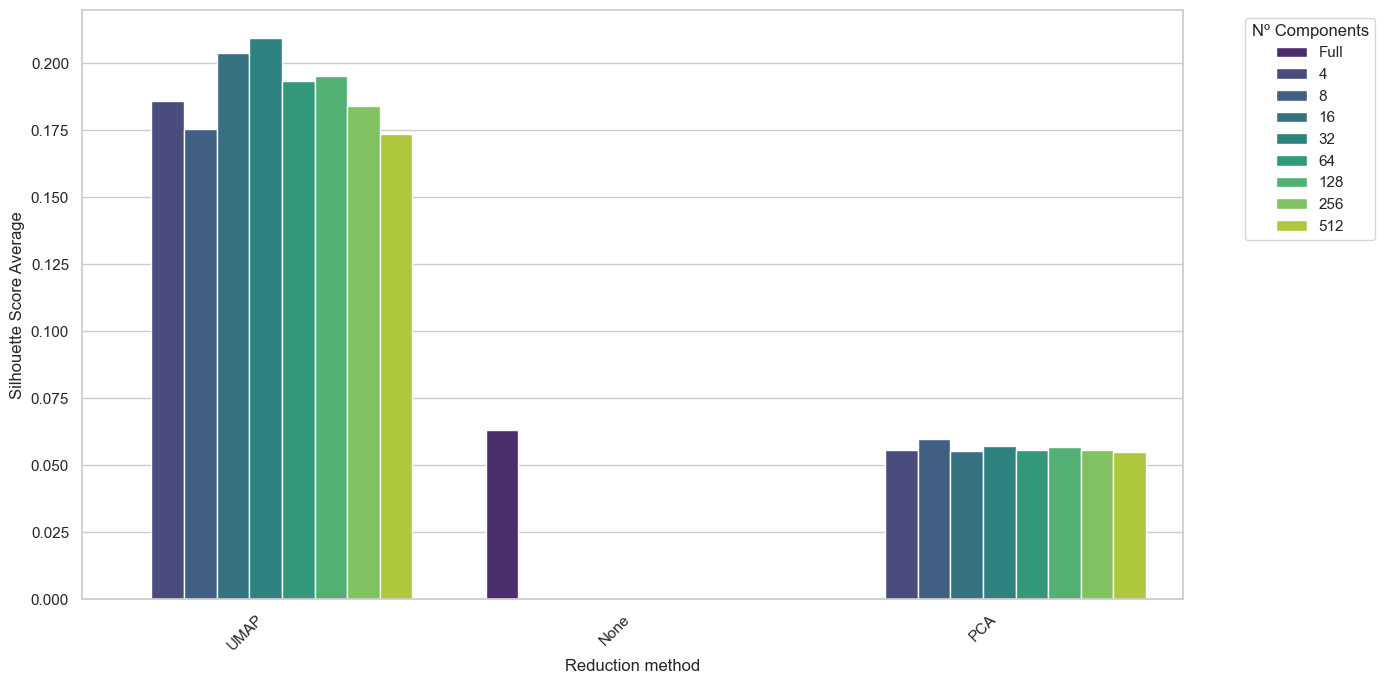

Média do Dunn Index por Cenário de Redução e N_Components


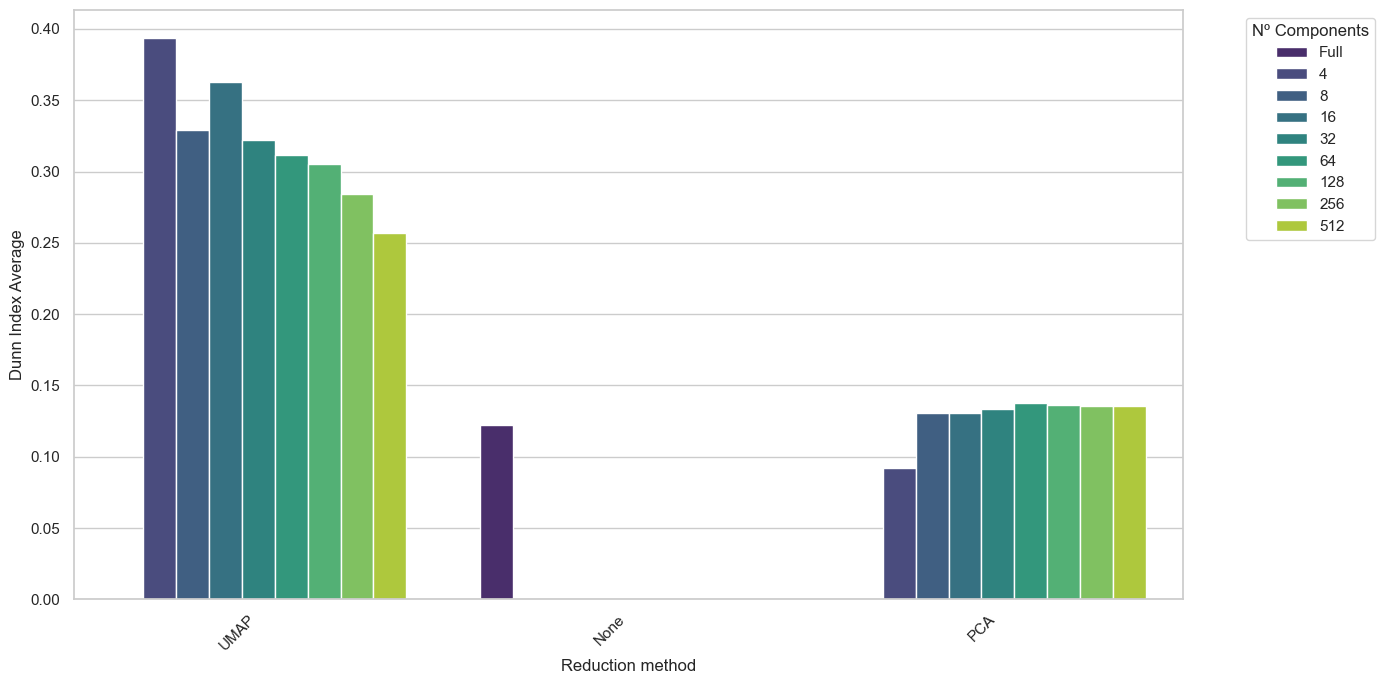


--- Cenário Selecionado para Otimização Fina dos Métodos de Clusterização (Globalmente) ---
Método de Redução: UMAP
Nº de Componentes: 32


In [13]:
if not master_results_df.empty:
    master_results_df['Silhouette'] = pd.to_numeric(master_results_df['Silhouette'], errors='coerce').astype(float)
    master_results_df['Dunn'] = pd.to_numeric(master_results_df['Dunn'], errors='coerce').astype(float)
    master_results_df['Actual_Clusters'] = pd.to_numeric(master_results_df['Actual_Clusters'], errors='coerce').astype(float)
    master_results_df['Input_K_Param'] = pd.to_numeric(master_results_df['Input_K_Param'], errors='coerce').astype(float)

    master_results_df.dropna(subset=['Silhouette', 'Dunn', 'Actual_Clusters'], inplace=True)
    
    min_clusters_threshold_for_analysis = 2 
    filtered_for_avg_analysis = master_results_df[master_results_df['Actual_Clusters'] >= min_clusters_threshold_for_analysis].copy()

    if filtered_for_avg_analysis.empty:
        print(f"\nNenhum resultado restante para análise após filtragem de clusters < {min_clusters_threshold_for_analysis}.")
    else:
        average_performance_by_scenario = filtered_for_avg_analysis.groupby([
            'Reduction_Method', 
            'N_Components'
        ]).agg(
            Avg_Silhouette=('Silhouette', 'mean'),
            Avg_Dunn=('Dunn', 'mean'),
        ).reset_index()

        overall_best_scenarios = average_performance_by_scenario.sort_values(
            by=['Avg_Silhouette', 'Avg_Dunn'], 
            ascending=[False, False]
        )

        print("\n--- Desempenho Médio dos Cenários de Redução (Global) ---")
        print("Esta tabela ajuda a identificar os melhores cenários de representação de embeddings.")
        print("Os cenários são ranqueados pela média do Silhouette e Dunn de TODAS as clusterizações nele.")
        print(overall_best_scenarios.head(10).to_string())

        print("\n--- Visualizando os Melhores Cenários de Redução ---")

        overall_best_scenarios['N_Components_Plot'] = overall_best_scenarios['N_Components'].astype(str)
        overall_best_scenarios['N_Components_Plot'] = pd.Categorical(overall_best_scenarios['N_Components_Plot'], 
                                                                    categories=sorted(overall_best_scenarios['N_Components_Plot'].unique(), 
                                                                                      key=lambda x: (x != 'Full', float(x) if x.replace('.','',1).isdigit() else x)), ordered=True)
        # Gráfico de barras para Scilhouette Score médio
        print("Média do Silhouette Score por Cenário de Redução e N_Components")
        plt.figure(figsize=(14, 7))
        sns.barplot(x='Reduction_Method', y='Avg_Silhouette', hue='N_Components_Plot', data=overall_best_scenarios, palette='viridis')
        plt.title('')
        plt.xlabel('Reduction method')
        plt.ylabel('Silhouette Score Average')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Nº Components', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        # Gráfico de barras para Dunn Index médio
        print("Média do Dunn Index por Cenário de Redução e N_Components")
        plt.figure(figsize=(14, 7))
        sns.barplot(x='Reduction_Method', y='Avg_Dunn', hue='N_Components_Plot', data=overall_best_scenarios, palette='viridis')
        plt.title('')
        plt.xlabel('Reduction method')
        plt.ylabel('Dunn Index Average')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Nº Components', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

        # --- Seleção do(s) Melhor(es) Cenário(s) para a Próxima Etapa ---
        
        selected_reduction_method = overall_best_scenarios.iloc[0]['Reduction_Method']
        selected_n_components = overall_best_scenarios.iloc[0]['N_Components']

        print(f"\n--- Cenário Selecionado para Otimização Fina dos Métodos de Clusterização (Globalmente) ---")
        print(f"Método de Redução: {selected_reduction_method}")
        print(f"Nº de Componentes: {selected_n_components}")
       
        global_selected_scenario_df = master_results_df[
            (master_results_df['Reduction_Method'] == selected_reduction_method) &
            (master_results_df['N_Components'] == selected_n_components)
        ].copy()

else:
    print("DataFrame mestre de resultados está vazio. Execute a célula anterior.")

In [12]:
# Filtra o DataFrame mestre para o melhor cenário
umap_32_results = master_results_df[
    (master_results_df['Reduction_Method'] == 'UMAP') &
    (master_results_df['N_Components'] == '32')
].copy()

if umap_32_results.empty:
    print("Nenhum resultado para o cenário UMAP 32. Verifique sua coleta de dados.")
else:
    print(f"\n--- Resultados para o Cenário UMAP 32 ({len(umap_32_results)} entradas) ---")
    print(umap_32_results.head())


--- Resultados para o Cenário UMAP 32 (595 entradas) ---
    Method      k  Silhouette      Dunn Dataset Reduction_Method N_Components  \
453  Agnes   10.0    0.364386  0.179692  Beauty             UMAP           32   
454  Agnes   30.0    0.291632  0.162549  Beauty             UMAP           32   
455  Agnes   50.0    0.278865  0.630374  Beauty             UMAP           32   
456  Agnes  100.0    0.260231  0.603695  Beauty             UMAP           32   
457  Agnes  150.0    0.250756  0.506592  Beauty             UMAP           32   

     Actual_Clusters  Input_K_Param  eps  min_samples  N_Clusters_Actual  \
453             10.0           10.0  NaN          NaN                NaN   
454             30.0           30.0  NaN          NaN                NaN   
455             50.0           50.0  NaN          NaN                NaN   
456            100.0          100.0  NaN          NaN                NaN   
457            150.0          150.0  NaN          NaN                NaN   


--- Etapa 3: Otimização Fina dos Métodos de Clusterização no Cenário Selecionado ---
Analisando no cenário: Redução=UMAP, N_Components=32
Dataset selecionado: ML-1M
k mínimo para plotar: 100

--- Gerando gráfico para o Método: Agnes no dataset ML-1M ---

Legenda do Gráfico de Desempenho para Agnes em ML-1M (Cenário: UMAP 32):
  - Linha Azul: Silhouette Score (eixo Y esquerdo)
  - Linha Vermelha: Dunn Index (eixo Y direito)
Desempenho de Agnes em ML-1M por Number of Clusters (k) (Cenário: UMAP 32)


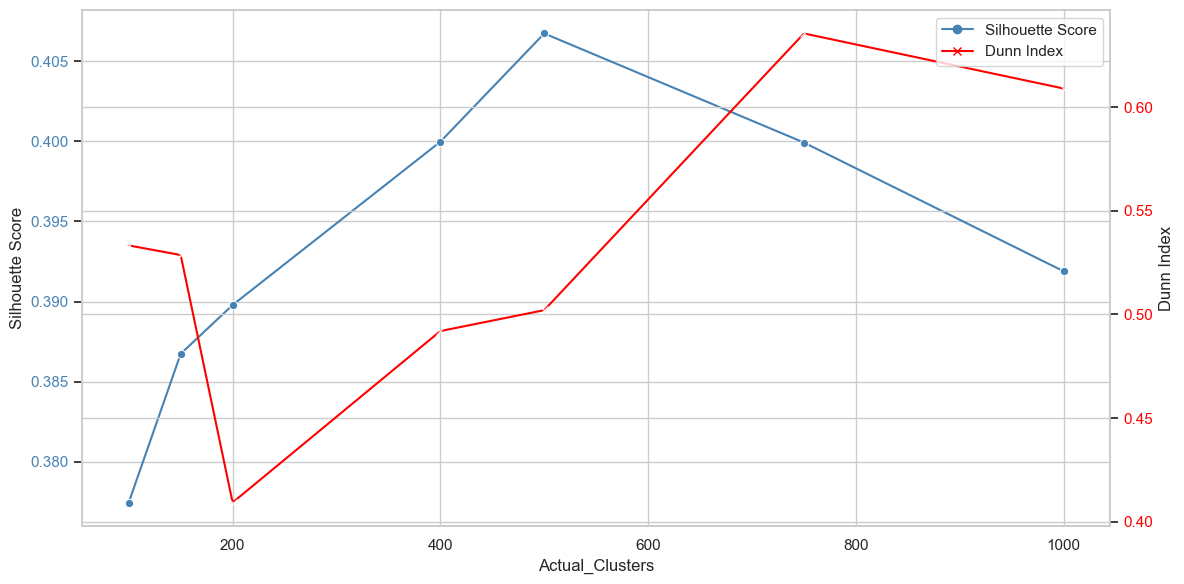


--- Gerando gráfico para o Método: Dbscan no dataset ML-1M ---
Nenhum resultado para o método Dbscan no dataset ML-1M com k >= 100.

--- Gerando gráfico para o Método: Dynmsc no dataset ML-1M ---

Legenda do Gráfico de Desempenho para Dynmsc em ML-1M (Cenário: UMAP 32):
  - Linha Azul: Silhouette Score (eixo Y esquerdo)
  - Linha Vermelha: Dunn Index (eixo Y direito)
Desempenho de Dynmsc em ML-1M por Number of Clusters (k) (Cenário: UMAP 32)


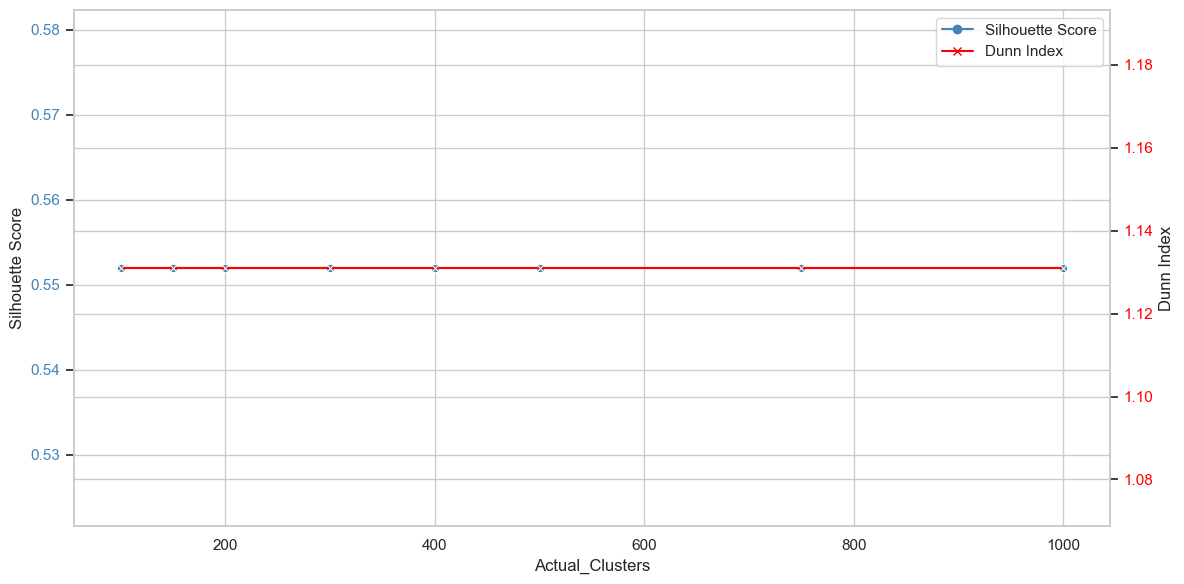


--- Gerando gráfico para o Método: Fastermsc no dataset ML-1M ---

Legenda do Gráfico de Desempenho para Fastermsc em ML-1M (Cenário: UMAP 32):
  - Linha Azul: Silhouette Score (eixo Y esquerdo)
  - Linha Vermelha: Dunn Index (eixo Y direito)
Desempenho de Fastermsc em ML-1M por Number of Clusters (k) (Cenário: UMAP 32)


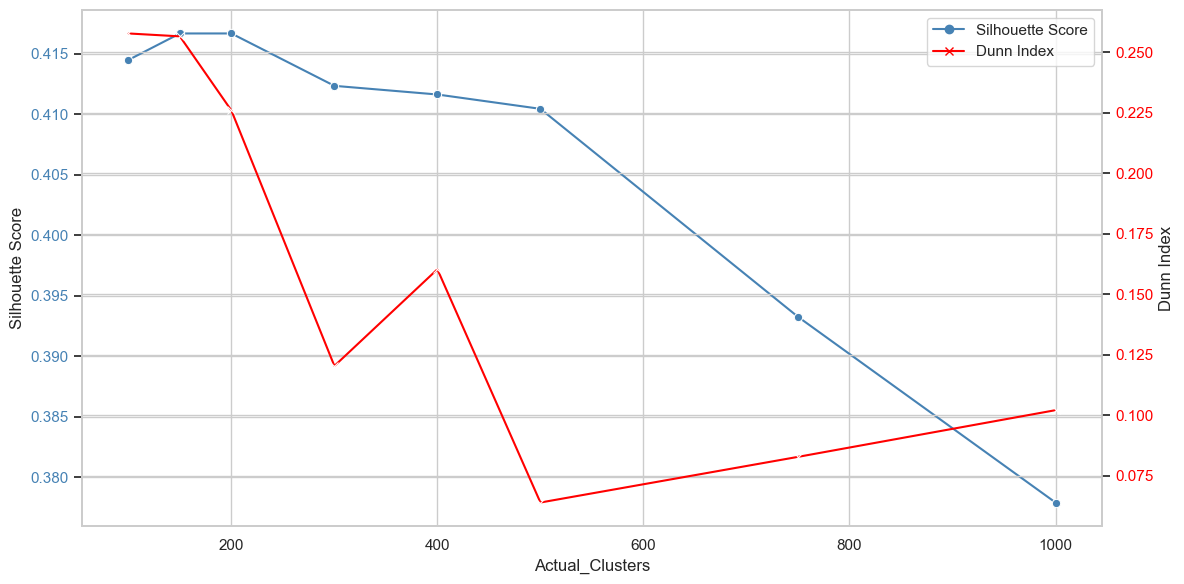


--- Gerando gráfico para o Método: Fasterpam no dataset ML-1M ---

Legenda do Gráfico de Desempenho para Fasterpam em ML-1M (Cenário: UMAP 32):
  - Linha Azul: Silhouette Score (eixo Y esquerdo)
  - Linha Vermelha: Dunn Index (eixo Y direito)
Desempenho de Fasterpam em ML-1M por Number of Clusters (k) (Cenário: UMAP 32)


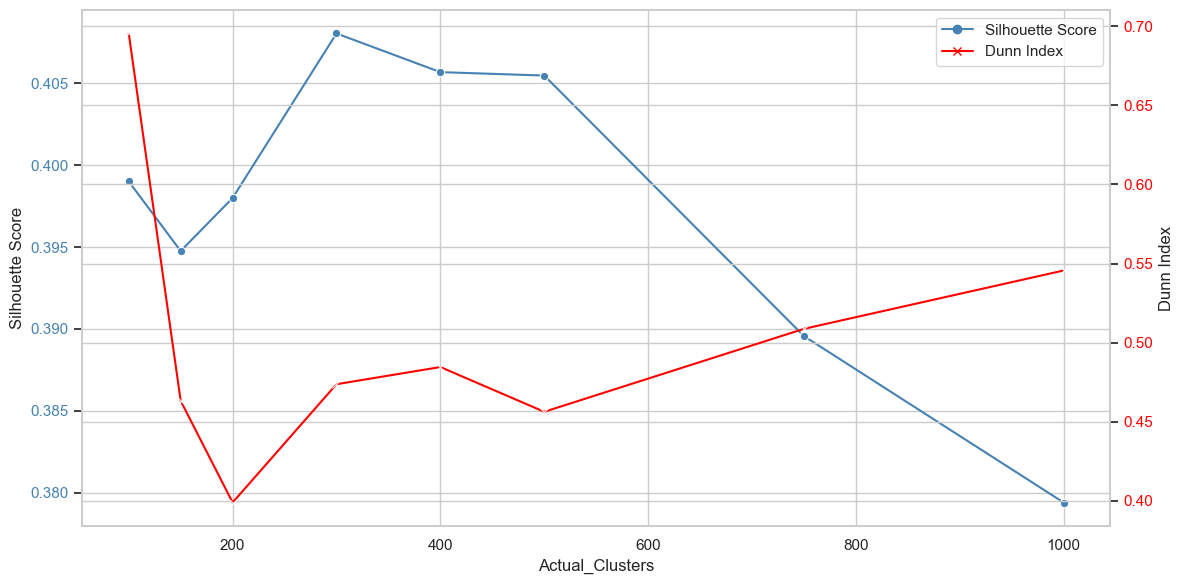


--- Gerando gráfico para o Método: Hdbscan no dataset ML-1M ---

Legenda do Gráfico de Desempenho para Hdbscan em ML-1M (Cenário: UMAP 32):
  - Linha Azul: Silhouette Score (eixo Y esquerdo)
  - Linha Vermelha: Dunn Index (eixo Y direito)
Desempenho de Hdbscan em ML-1M por Number of Clusters (k) (Cenário: UMAP 32)


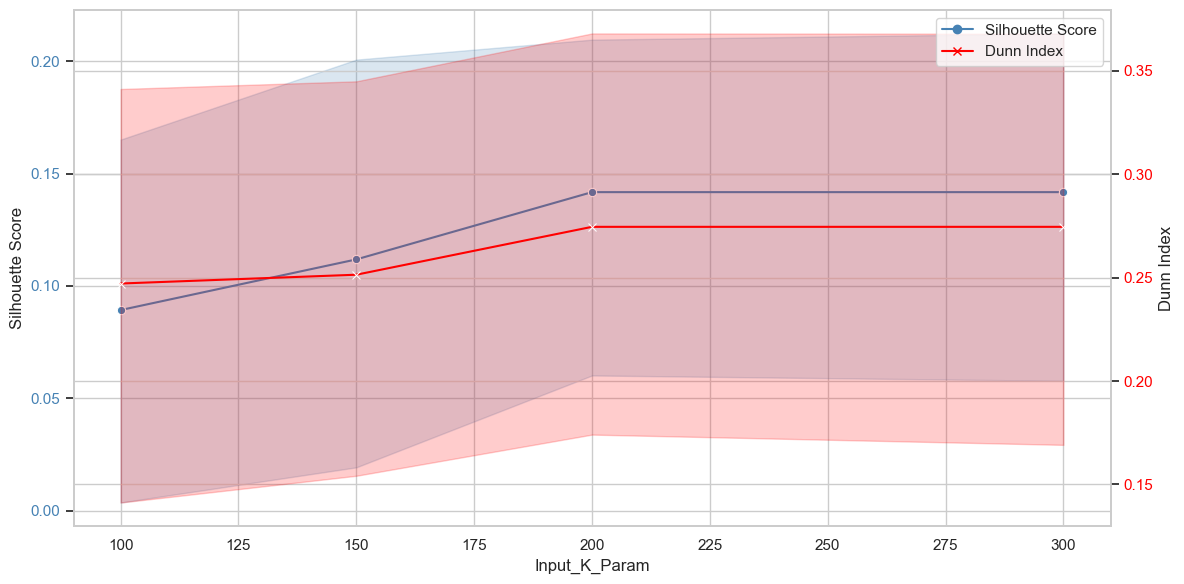


--- Gerando gráfico para o Método: Kmeans no dataset ML-1M ---

Legenda do Gráfico de Desempenho para Kmeans em ML-1M (Cenário: UMAP 32):
  - Linha Azul: Silhouette Score (eixo Y esquerdo)
  - Linha Vermelha: Dunn Index (eixo Y direito)
Desempenho de Kmeans em ML-1M por Number of Clusters (k) (Cenário: UMAP 32)


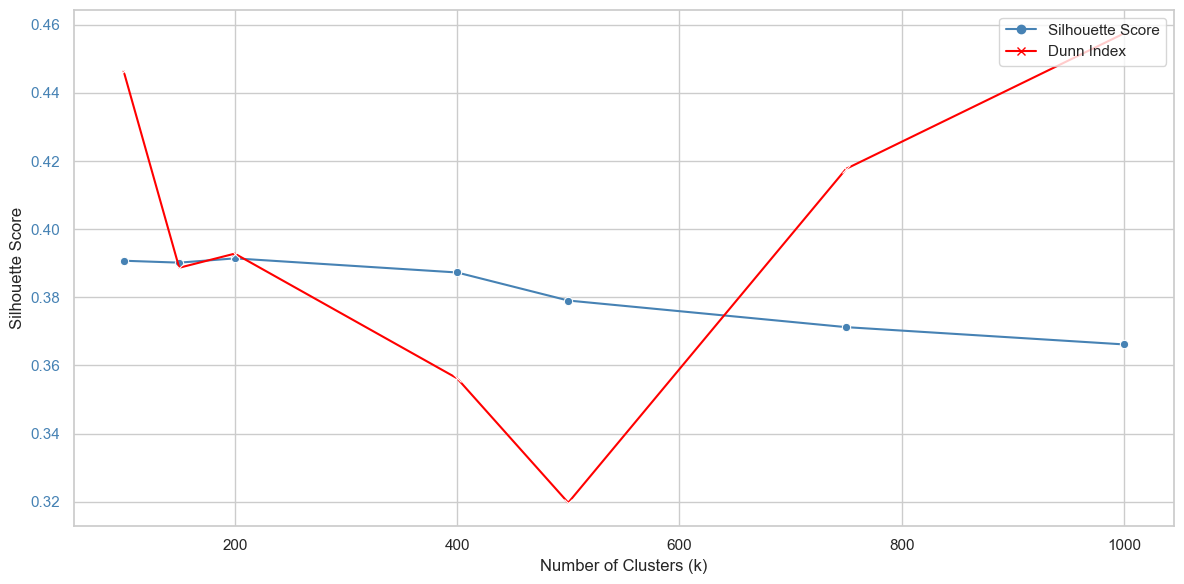


--- Gerando gráfico para o Método: Spectral no dataset ML-1M ---

Legenda do Gráfico de Desempenho para Spectral em ML-1M (Cenário: UMAP 32):
  - Linha Azul: Silhouette Score (eixo Y esquerdo)
  - Linha Vermelha: Dunn Index (eixo Y direito)
Desempenho de Spectral em ML-1M por Number of Clusters (k) (Cenário: UMAP 32)


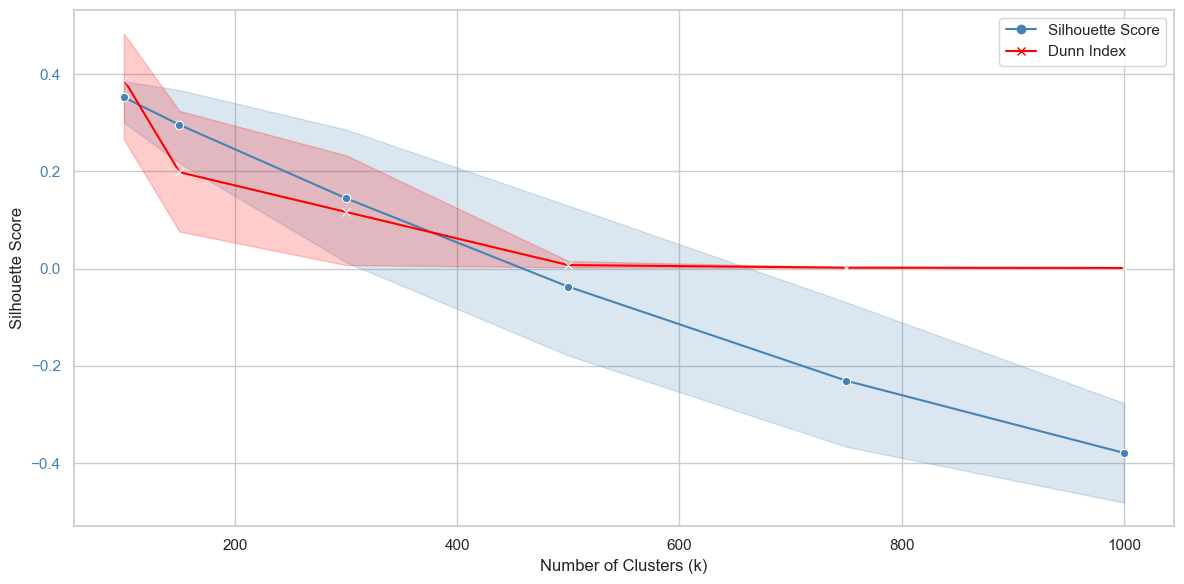

In [ ]:
# Defina aqui o dataset e o valor mínimo de k antes de executar o bloco:
chosen_dataset = "ML-1M" 
min_k = 100  

if 'global_selected_scenario_df' in locals() and not global_selected_scenario_df.empty:

    print("\n--- Etapa 3: Otimização Fina dos Métodos de Clusterização no Cenário Selecionado ---")
    print(f"Analisando no cenário: Redução={selected_reduction_method}, N_Components={selected_n_components}")
    print(f"Dataset selecionado: {chosen_dataset}")
    print(f"k mínimo para plotar: {min_k}")

    # Verifica se o dataset escolhido existe no DataFrame
    all_datasets_in_scenario = global_selected_scenario_df['Dataset'].unique()
    if chosen_dataset not in all_datasets_in_scenario:
        print(f"\nDataset '{chosen_dataset}' não encontrado em global_selected_scenario_df.")
    else:
        # Filtra apenas o dataset definido
        current_dataset_scenario_df = global_selected_scenario_df[
            global_selected_scenario_df['Dataset'] == chosen_dataset
        ].copy()

        unique_methods_in_dataset = current_dataset_scenario_df['Method'].unique()

        for method in unique_methods_in_dataset:
            print(f"\n--- Gerando gráfico para o Método: {method} no dataset {chosen_dataset} ---")
            method_df = current_dataset_scenario_df[
                current_dataset_scenario_df['Method'] == method
            ].copy()

            # Define qual coluna usar no eixo X
            x_axis_col = (
                'Input_K_Param'
                if 'Input_K_Param' in method_df.columns
                and not method_df['Input_K_Param'].isnull().all()
                and pd.api.types.is_numeric_dtype(method_df['Input_K_Param'])
                and not method_df['Input_K_Param'].equals(method_df['Actual_Clusters'])
                else 'Actual_Clusters'
            )
            x_axis_label_plot = 'Number of Clusters (k)'

            # Ordena e filtra pelos valores de k >= min_k
            method_df_sorted = method_df.sort_values(by=x_axis_col)
            method_df_sorted = method_df_sorted[method_df_sorted[x_axis_col] >= min_k]

            if method_df_sorted.empty:
                print(f"Nenhum resultado para o método {method} no dataset {chosen_dataset} com k >= {min_k}.")
                continue

            print(f"\nLegenda do Gráfico de Desempenho para {method} em {chosen_dataset} "
                  f"(Cenário: {selected_reduction_method} {selected_n_components}):")
            print("  - Linha Azul: Silhouette Score (eixo Y esquerdo)")
            print("  - Linha Vermelha: Dunn Index (eixo Y direito)")

            # --- Visualização das Métricas vs. Nº de Clusters/Parâmetros ---
            plt.figure(figsize=(12, 6))

            # Primeiro eixo Y (Silhouette Score)
            ax1 = sns.lineplot(
                x=x_axis_col,
                y='Silhouette',
                data=method_df_sorted,
                marker='o',
                color='steelblue'
            )
            ax1.set_ylabel('Silhouette Score')
            ax1.tick_params(axis='y', labelcolor='steelblue')

            # Segundo eixo Y (Dunn Index), se necessário
            if (
                method_df_sorted['Dunn'].max() > 1.5 * method_df_sorted['Silhouette'].max()
                or method_df_sorted['Dunn'].min() < 0.5 * method_df_sorted['Silhouette'].min()
            ):
                ax2 = ax1.twinx()
                sns.lineplot(
                    x=x_axis_col,
                    y='Dunn',
                    data=method_df_sorted,
                    marker='x',
                    color='red',
                    ax=ax2
                )
                ax2.set_ylabel('Dunn Index')
                ax2.tick_params(axis='y', labelcolor='red')
            else:
                sns.lineplot(
                    x=x_axis_col,
                    y='Dunn',
                    data=method_df_sorted,
                    marker='x',
                    color='red',
                    ax=ax1
                )

            lines = [
                plt.Line2D([0], [0], color='steelblue', marker='o', linestyle='-'),
                plt.Line2D([0], [0], color='red', marker='x', linestyle='-')
            ]
            labels = ['Silhouette Score', 'Dunn Index']
            plt.legend(lines, labels, loc='upper right')

            print(f'Desempenho de {method} em {chosen_dataset} por {x_axis_label_plot} '
                  f"(Cenário: {selected_reduction_method} {selected_n_components})")
            plt.xlabel(x_axis_label_plot)

            plt.tight_layout()
            plt.show()

else:
    print("DataFrame global_selected_scenario_df não foi definido ou está vazio. Execute a célula anterior.")


In [7]:
if 'global_selected_scenario_df' in locals() and not global_selected_scenario_df.empty:
    print("\n--- Melhores Ajustes de Parâmetros por Método e Dataset ---")
    print(f"Analisando no cenário: Redução={selected_reduction_method}, N_Components={selected_n_components}")

    # --- PARÂMETROS DE FILTRO E EXIBIÇÃO ---
    dataset_to_filter = 'ML-1M' 
    top_n_display = 10 

    all_datasets_in_scenario = global_selected_scenario_df['Dataset'].unique()

    # Iterar por CADA DATASET dentro do cenário selecionado
    for dataset_name in all_datasets_in_scenario:
        if dataset_to_filter is not None and dataset_name != dataset_to_filter:
            continue

        print(f"\n***** Tabela de Melhores Ajustes para o Dataset: {dataset_name} *****")
        current_dataset_scenario_df = global_selected_scenario_df[
            global_selected_scenario_df['Dataset'] == dataset_name
        ].copy()

        unique_methods_in_dataset = current_dataset_scenario_df['Method'].unique()

        # Iterar por CADA MÉTODO de clusterização dentro do dataset atual
        for method in unique_methods_in_dataset:
            method_df = current_dataset_scenario_df[current_dataset_scenario_df['Method'] == method].copy()

            if method_df.empty:
                print(f"Nenhum resultado para o método {method} no dataset {dataset_name}.")
                continue

            # --- DEFINIÇÃO DINÂMICA DAS COLUNAS DE EXIBIÇÃO ---
            # Colunas básicas
            display_columns_base = ['Actual_Clusters', 'Silhouette', 'Dunn']
            # Rótulos amigáveis
            display_columns_labels = {'Actual_Clusters': 'Nº de Clusters (k)', 'Silhouette': 'Silhouette', 'Dunn': 'Dunn'}
            
            
            if 'Input_K_Param' in method_df.columns and not method_df['Input_K_Param'].isnull().all():
                if method_df['Input_K_Param'].equals(method_df['Actual_Clusters']): 
                    pass 
                else: # HDBSCAN e outros com Input_K_Param distinto
                    display_columns_base.insert(0, 'Input_K_Param')
                    display_columns_labels['Input_K_Param'] = 'Param. k/MinSize'
            
            if 'Input_Eps_Param' in method_df.columns and not method_df['Input_Eps_Param'].isnull().all():
                display_columns_base.insert(1, 'Input_Eps_Param')
                display_columns_labels['Input_Eps_Param'] = 'Param. Eps'
            
            if 'Input_MinSamples_Param' in method_df.columns and not method_df['Input_MinSamples_Param'].isnull().all():
                display_columns_base.insert(2, 'Input_MinSamples_Param')
                display_columns_labels['Input_MinSamples_Param'] = 'Param. MinSamples'
            
            if 'Input_NNeighbors_Param' in method_df.columns and not method_df['Input_NNeighbors_Param'].isnull().all():
                display_columns_base.insert(3, 'Input_NNeighbors_Param')
                display_columns_labels['Input_NNeighbors_Param'] = 'Param. N_Neighbors'
            
            
            columns_to_show_raw = ['Input_K_Param', 'Input_Eps_Param', 'Input_MinSamples_Param', 'Input_NNeighbors_Param', 'Actual_Clusters', 'Silhouette', 'Dunn']
            final_display_cols = [col for col in columns_to_show_raw if col in display_columns_base]
            
            # Top N por Silhouette
            top_silhouette = method_df.sort_values(by='Silhouette', ascending=False).head(top_n_display).copy() 
            top_silhouette = top_silhouette[final_display_cols].rename(columns=display_columns_labels)
            print(f"\nTop {top_n_display} configurações de {method} por Silhouette Score em {dataset_name}:")
            print(top_silhouette.to_string(index=False))

            # Top N por Dunn
            top_dunn = method_df.sort_values(by='Dunn', ascending=False).head(top_n_display).copy() 
            top_dunn = top_dunn[final_display_cols].rename(columns=display_columns_labels)
            print(f"\nTop {top_n_display} configurações de {method} por Dunn Index em {dataset_name}:")
            print(top_dunn.to_string(index=False))
            
else:
    print("DataFrame global_selected_scenario_df não foi definido ou está vazio. Execute a Célula 4.")


--- Melhores Ajustes de Parâmetros por Método e Dataset ---
Analisando no cenário: Redução=UMAP, N_Components=32

***** Tabela de Melhores Ajustes para o Dataset: ML-1M *****

Top 10 configurações de Agnes por Silhouette Score em ML-1M:
 Nº de Clusters (k)  Silhouette     Dunn
                5.0    0.417341 0.804428
              500.0    0.406731 0.502091
              400.0    0.399977 0.491996
              750.0    0.399924 0.635746
             1000.0    0.391895 0.609150
              200.0    0.389790 0.409178
              150.0    0.386745 0.528722
              100.0    0.377469 0.533356
               50.0    0.366749 0.679721
               10.0    0.351325 0.772874

Top 10 configurações de Agnes por Dunn Index em ML-1M:
 Nº de Clusters (k)  Silhouette     Dunn
                5.0    0.417341 0.804428
               10.0    0.351325 0.772874
               30.0    0.344107 0.729271
               50.0    0.366749 0.679721
              750.0    0.399924 0.635746
         

# Visualização Cosine vs Euclidean
Nos metodos FasterPAM, FasterMSC e DynMSC

In [8]:
# import pandas as pd
# import os

In [9]:
# results_paths = {
#     'cosine': 'clusters/ML-1M/embeddings_completos',
#     'euclidean': 'clusters/ML-1M/embeddings_completos_metricastrocadas'
# }
# kmedoids_methods = ['run_fasterpam', 'run_fastermsc', 'run_dynmsc']
# all_kmedoids_results = []


In [10]:
# for metric_type, base_path in results_paths.items():
#     for method_name in kmedoids_methods:
#         file_path = os.path.join(base_path, f'ML-1M_{method_name}_results.csv')

#         if os.path.exists(file_path):
#             df = pd.read_csv(file_path)
#             df['Metric_Distance'] = metric_type
#             all_kmedoids_results.append(df)
#         else:
#             print(f"Arquivo não encontrado: {file_path}")

In [11]:
# combined_df = pd.concat(all_kmedoids_results, ignore_index=True)

# best_results_per_combination = []

# for method_name in kmedoids_methods:
#     for metric_type in results_paths.keys():
#         filtered_df = combined_df[(combined_df['Method'] == method_name) &
#                                     (combined_df['Metric_Distance'] == metric_type)].copy()

#         if not filtered_df.empty:
#             best_silhouette_row = filtered_df.loc[filtered_df['Silhouette'].idxmax()]
#             best_silhouette_row['Best_For_Metric'] = 'Silhouette'
#             best_results_per_combination.append(best_silhouette_row)

#             if filtered_df['Dunn'].idxmax() != filtered_df['Silhouette'].idxmax():
#                 best_dunn_row = filtered_df.loc[filtered_df['Dunn'].idxmax()]
#                 best_dunn_row['Best_For_Metric'] = 'Dunn'
#                 best_results_per_combination.append(best_dunn_row)
#         else:
#             best_results_per_combination.append({
#                 'Method': method_name,
#                 'Metric_Distance': metric_type,
#                 'k': None,
#                 'Silhouette': None,
#                 'Dunn': None,
#                 'Best_For_Metric': 'N/A (No Results)'
#             })


# final_comparison_df = pd.DataFrame(best_results_per_combination).drop_duplicates(subset=['Method', 'Metric_Distance', 'k']).sort_values(
#     by=['Method', 'Metric_Distance', 'Silhouette'], ascending=[True, True, False]
# )

# display_df = final_comparison_df[['Method', 'Metric_Distance', 'k', 'Silhouette', 'Dunn']].copy()
# display_df.rename(columns={'k': 'Nº de Clusters (k)', 'Metric_Distance': 'Métrica de Distância'}, inplace=True)
# display_df['Method'] = display_df['Method'].str.replace('run_', '').str.capitalize()

# print("\n--- Comparação dos Métodos K-Medoids (ML-1M, Sem Redução, por Métrica de Distância) ---")
# print(display_df.to_string(index=False))

# display_df.to_csv('kmedoids_ml1m_metric_comparison.csv', index=False)
